# Wczytywanie danych

In [ ]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
print("\n LOADED FILE: "+fn)

# Wczytywanie zależności

In [2]:
!pip install pyspark

# Inicjalizacja środowiska Apache Spark w trybie lokalnym:

* Tworzenie nowej sesji Spark przy użyciu wzorca Builder
* Konfiguracja podstawowych parametrów: nazwa aplikacji ("ColabSpark"), port interfejsu użytkownika (4050)
* Ustawienie trybu wykonania na lokalny z wykorzystaniem wszystkich dostępnych rdzeni procesora ('local[*]')

W Apache Spark dostępne są następujące główne tryby wykonania (master URL):
Tryby lokalne:
* 'local' - pojedynczy wątek
* 'local[N]' - N wątków (np. 'local[4]' dla 4 wątków)
* 'local[*]' - automatyczne wykrycie liczby rdzeni

Tryby klastrowe:
* 'spark://HOST:PORT' - połączenie ze standalone klastrem Spark
* 'yarn' - uruchomienie na klastrze YARN (Hadoop)
* 'mesos://HOST:PORT' - uruchomienie na klastrze Mesos
* 'k8s://HOST:PORT' - uruchomienie na klastrze Kubernetes

Przykład zmiany konfiguracji na klaster YARN:
spark = SparkSession.builder \
    .appName("ColabSpark") \
    .master('yarn') \
    .getOrCreate()

In [4]:
# Importujemy główną klasę do tworzenia sesji Spark
from pyspark.sql import SparkSession

# Tworzymy nową sesję Spark używając wzorca Builder:
# Podajemy nazwę aplikacji widoczną w interfejsie Spark UI
# Konfigurujemy port dla Spark UI - Colab wymaga jawnej konfiguracji portu
# Określamy tryb uruchomienia:
 # 'local[*]' oznacza lokalny tryb używający wszystkich dostępnych rdzeni
 # gwiazdka * oznacza automatyczne wykrycie liczby rdzeni
spark = (SparkSession.builder
         .appName("ColabSpark")
         .config('spark.ui.port', '4050')
         .master('local[*]')
         .getOrCreate())

# Wyświetlamy wersję Spark do weryfikacji poprawności instalacji
print(f"Wersja Spark: {spark.version}")

Wersja Spark: 3.5.3


# Demonstracja wpływu liczby rdzeni na wydajność przetwarzania w Spark:

* Tworzenie sesji Spark z różną liczbą rdzeni (1, 2, 4 i wszystkie dostępne)
* Generowanie testowego zbióru danych zawierającego 1 milion rekordów
* Wykonanie operacji grupowania i zliczania na danych
* Zmierzenie czasu wykonania operacji dla każdej konfiguracji rdzeni

Przykład badania skalowalności obliczeń równoległych w Spark, pokazujący jak zwiększenie liczby rdzeni wpływa na czas przetwarzania tej samej operacji na dużym zbiorze danych. Praktyczne zastosowanie w analizie wydajności systemów rozproszonych.

In [5]:
import time
from pyspark.sql import SparkSession
import numpy as np

# Funkcja tworząca sesję Spark z określoną liczbą rdzeni
def create_spark_session(cores):
    return (SparkSession.builder
            .appName(f"SparkCores_{cores}")
            .master(f"local[{cores}]")  # Tu określamy liczbę rdzeni
            .getOrCreate())

# Przygotowanie danych testowych - duża lista liczb
data = [(i, i % 10) for i in range(1000000)]

# Test dla różnej liczby rdzeni
for cores in [1, 2, 4, '*']:  # '*' oznacza wszystkie dostępne rdzenie
    # Zamykamy poprzednią sesję
    SparkSession.builder.getOrCreate().stop()

    # Tworzymy nową sesję z określoną liczbą rdzeni
    spark = create_spark_session(cores)

    # Tworzymy DataFrame
    df = spark.createDataFrame(data, ["id", "value"])

    # Start pomiaru czasu
    start_time = time.time()

    # Wykonujemy operację wymagającą obliczeń
    result = df.groupBy("value").count().collect()

    # Koniec pomiaru
    duration = time.time() - start_time

    print(f"Liczba rdzeni: {cores}")
    print(f"Czas wykonania: {duration:.2f} sekund")
    print("-" * 30)

Liczba rdzeni: 1
Czas wykonania: 8.02 sekund
------------------------------
Liczba rdzeni: 2
Czas wykonania: 3.39 sekund
------------------------------
Liczba rdzeni: 4
Czas wykonania: 3.43 sekund
------------------------------
Liczba rdzeni: *
Czas wykonania: 3.23 sekund
------------------------------


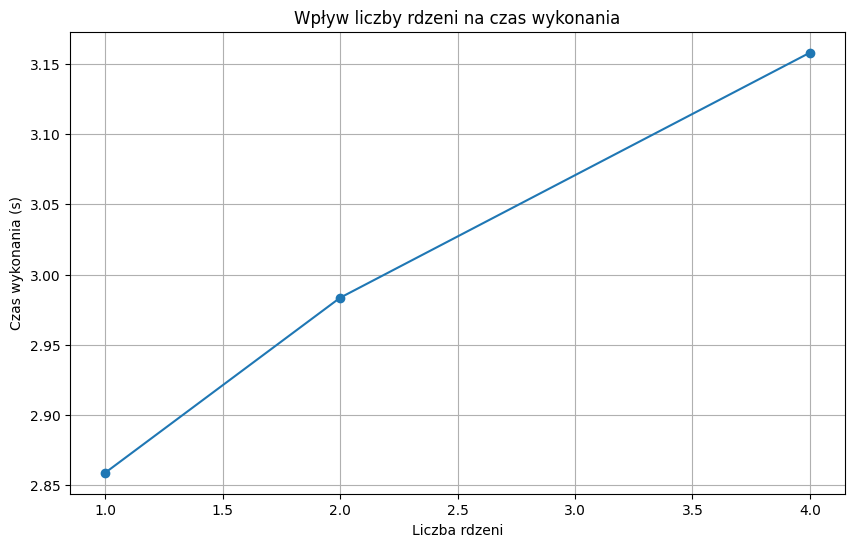

In [6]:
# Dodajemy wykres porównawczy
import matplotlib.pyplot as plt

times = []  # Tu będziemy zbierać czasy
cores_list = [1, 2, 4]  # Bez '*' dla czytelności wykresu

for cores in cores_list:
    SparkSession.builder.getOrCreate().stop()
    spark = create_spark_session(cores)
    df = spark.createDataFrame(data, ["id", "value"])

    start_time = time.time()
    result = df.groupBy("value").count().collect()
    duration = time.time() - start_time
    times.append(duration)

plt.figure(figsize=(10, 6))
plt.plot(cores_list, times, marker='o')
plt.xlabel('Liczba rdzeni')
plt.ylabel('Czas wykonania (s)')
plt.title('Wpływ liczby rdzeni na czas wykonania')
plt.grid(True)
plt.show()

# Realizacja kompleksowego porównania wydajności przetwarzania danych między Pandas a Spark z różnymi konfiguracjami rdzeni:

1. Monitorowanie w czasie rzeczywistym wykorzystania CPU w osobnym wątku
2. Wykonywanie tej samej operacji grupowania na zbiorze 1 miliona rekordów z użyciem:
* Pandas (jednowątkowo)
* Spark w różnych konfiguracjach (1, 2, 4 i wszystkie rdzenie)

3. Generowanie wykresów pokazujących:
* Zużycie CPU w czasie dla każdej konfiguracji Spark
* Porównanie czasów wykonania między Pandas a różnymi konfiguracjami Spark

Zaawansowany kod do analizy wydajności, pozwalający zrozumieć różnice między przetwarzaniem sekwencyjnym (Pandas) a równoległym (Spark) oraz wpływ liczby rdzeni na efektywność obliczeń.

Uruchamiam test Pandas...
Czas Pandas: 0.02 sekund

Uruchamiam test Spark z 1 rdzeniami...
Czas Spark (1 rdzeni): 3.75 sekund
Średnie użycie CPU: 99.2%


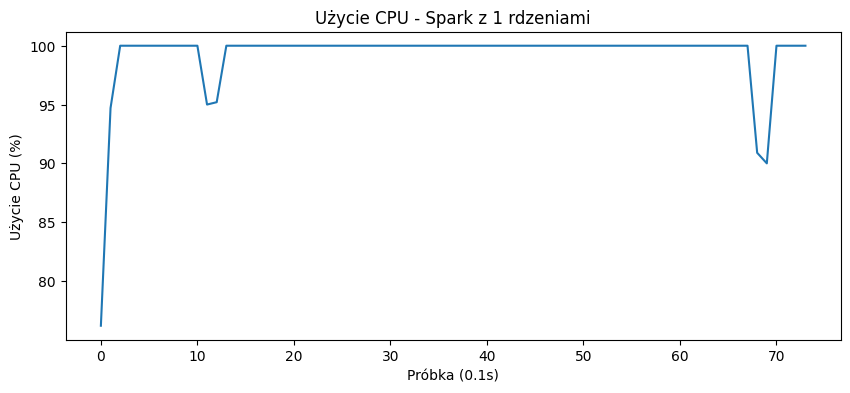


Uruchamiam test Spark z 2 rdzeniami...
Czas Spark (2 rdzeni): 3.61 sekund
Średnie użycie CPU: 95.5%


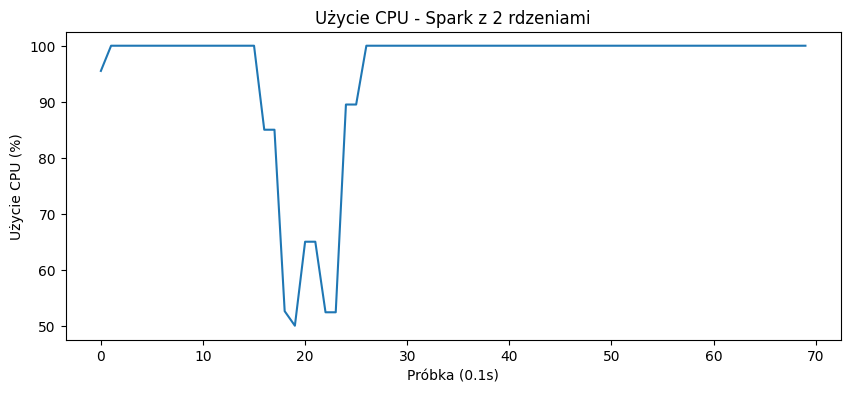


Uruchamiam test Spark z 4 rdzeniami...
Czas Spark (4 rdzeni): 2.90 sekund
Średnie użycie CPU: 88.3%


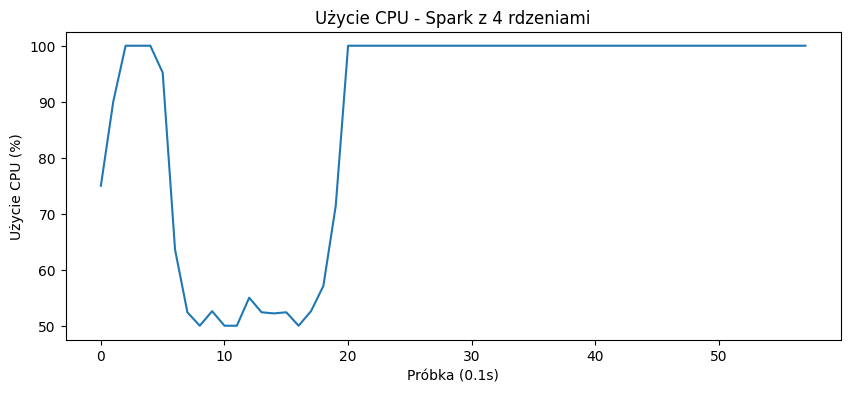


Uruchamiam test Spark z * rdzeniami...
Czas Spark (* rdzeni): 2.74 sekund
Średnie użycie CPU: 89.0%


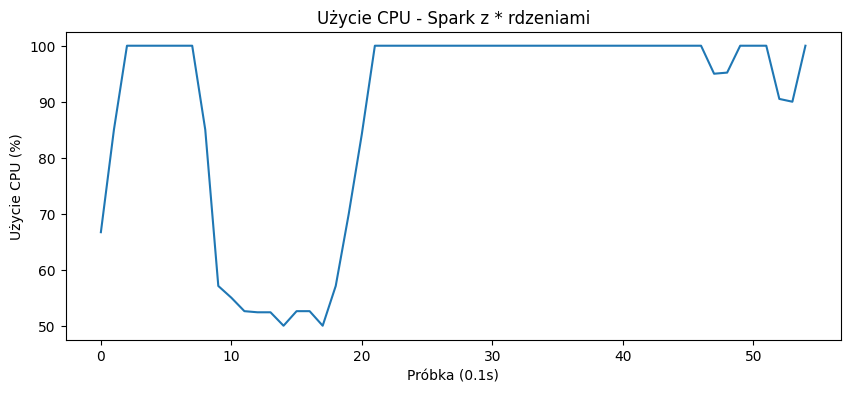

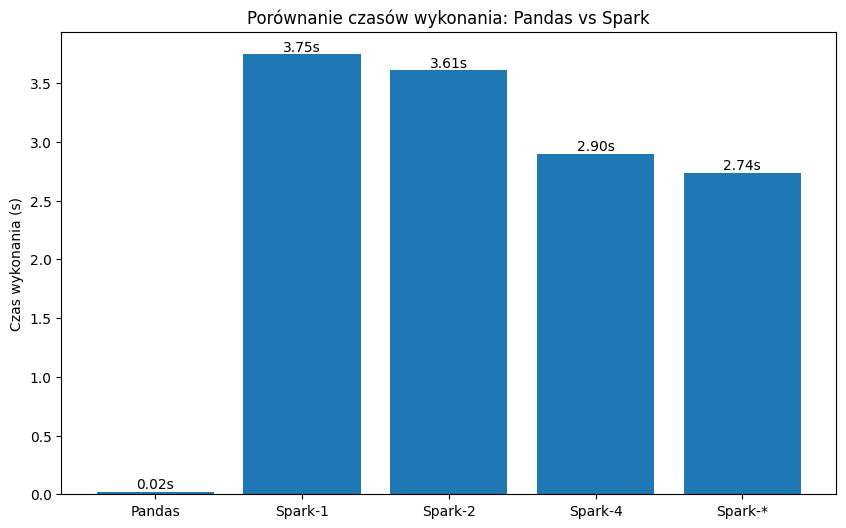

In [8]:
import time
from pyspark.sql import SparkSession
import numpy as np
import pandas as pd
import psutil
import matplotlib.pyplot as plt
from threading import Thread
import queue

# Kolejka do przechowywania odczytów CPU
cpu_usage_queue = queue.Queue()

# Funkcja monitorująca CPU
def monitor_cpu():
    while True:
        cpu_percent = psutil.cpu_percent(interval=0.1)
        cpu_usage_queue.put(cpu_percent)
        if cpu_usage_queue.qsize() > 100:  # Limit historii
            cpu_usage_queue.get()

# Start monitorowania CPU w osobnym wątku
monitor_thread = Thread(target=monitor_cpu, daemon=True)
monitor_thread.start()

# Funkcja do testowania wydajności
def run_performance_test(data_size=1000000):
    # Przygotowanie danych
    data = [(i, i % 10) for i in range(data_size)]

    # Test Pandas
    print("Uruchamiam test Pandas...")
    df_pandas = pd.DataFrame(data, columns=["id", "value"])
    start_time = time.time()
    result_pandas = df_pandas.groupby("value").size()
    pandas_time = time.time() - start_time
    print(f"Czas Pandas: {pandas_time:.2f} sekund")

    # Testy Spark dla różnych konfiguracji rdzeni
    spark_times = []
    cores_list = [1, 2, 4, '*']

    for cores in cores_list:
        print(f"\nUruchamiam test Spark z {cores} rdzeniami...")
        # Zatrzymanie poprzedniej sesji
        SparkSession.builder.getOrCreate().stop()

        # Nowa sesja
        spark = (SparkSession.builder
                .appName(f"SparkCores_{cores}")
                .master(f"local[{cores}]")
                .getOrCreate())

        # Tworzenie i przetwarzanie DataFrame
        df_spark = spark.createDataFrame(data, ["id", "value"])

        # Czyszczenie kolejki CPU przed testem
        while not cpu_usage_queue.empty():
            cpu_usage_queue.get()

        start_time = time.time()
        result_spark = df_spark.groupBy("value").count().collect()
        spark_time = time.time() - start_time

        # Zbieranie wyników CPU
        cpu_usage = []
        while not cpu_usage_queue.empty():
            cpu_usage.append(cpu_usage_queue.get())

        print(f"Czas Spark ({cores} rdzeni): {spark_time:.2f} sekund")
        print(f"Średnie użycie CPU: {np.mean(cpu_usage):.1f}%")
        spark_times.append(spark_time)

        # Rysowanie wykresu użycia CPU
        plt.figure(figsize=(10, 4))
        plt.plot(cpu_usage)
        plt.title(f'Użycie CPU - Spark z {cores} rdzeniami')
        plt.xlabel('Próbka (0.1s)')
        plt.ylabel('Użycie CPU (%)')
        plt.show()

    # Wykres porównawczy czasów
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(len(cores_list) + 1), [pandas_time] + spark_times)
    plt.xticks(range(len(cores_list) + 1), ['Pandas'] + [f'Spark-{c}' for c in cores_list])
    plt.ylabel('Czas wykonania (s)')
    plt.title('Porównanie czasów wykonania: Pandas vs Spark')

    # Dodanie etykiet z czasami nad słupkami
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}s',
                ha='center', va='bottom')

    plt.show()

# Uruchomienie testu
run_performance_test(1000000)  # 1 milion rekordów

# Realizacja kompleksowego porównania wydajności przetwarzania danych między Pandas a Spark, z rozszerzonym monitoringiem zasobów:
1. Testowanie wydajności dla różnych wielkości danych (100k, 1M, 5M rekordów)
2. Monitorowanie w czasie rzeczywistym:
* Wykorzystania CPU
* Zużycia pamięci RAM
3. Wykonanie serii złożonych operacji na danych:
* Grupowanie
* Agregacje
* Obliczenia
* Filtrowanie
* Sortowanie
4. Porównanie wydajności między:
* Pandas (przetwarzanie sekwencyjne)
* Spark w różnych konfiguracjach rdzeni (1, 2, 4, wszystkie)
5. Generowanie szczegółowych wykresów pokazujących:
* Użycie CPU i RAM w czasie
* Porównanie czasów wykonania

Zaawansowany kod do analizy wydajności, pozwalający kompleksowo zbadać zachowanie systemów przetwarzania danych pod kątem wykorzystania zasobów i czasu wykonania.


Test dla 100,000 rekordów
--------------------------------------------------
Uruchamiam test Pandas...
Czas Pandas: 0.01 sekund

Test Spark z 1 rdzeniami...
Czas wykonania: 2.80 sekund
Średnie użycie CPU: 92.2%
Średnie użycie RAM: 16.1%


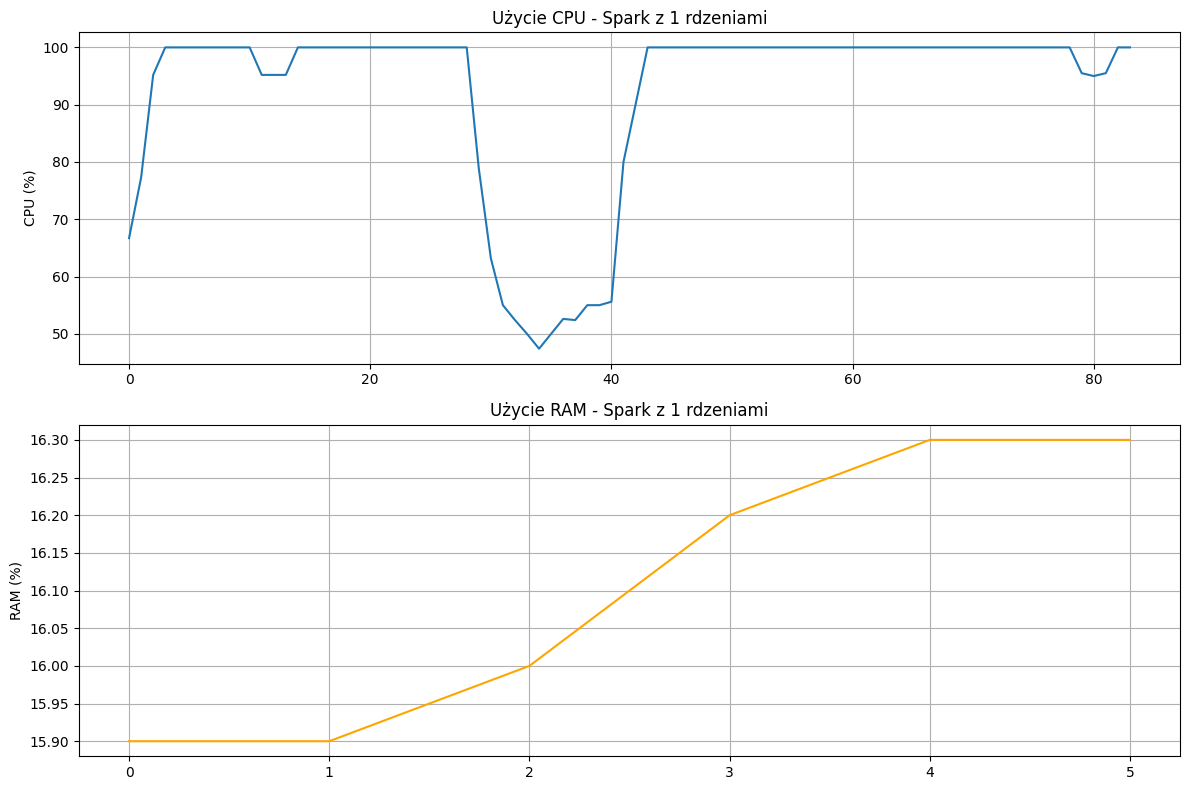


Test Spark z 2 rdzeniami...
Czas wykonania: 2.29 sekund
Średnie użycie CPU: 93.3%
Średnie użycie RAM: 16.1%


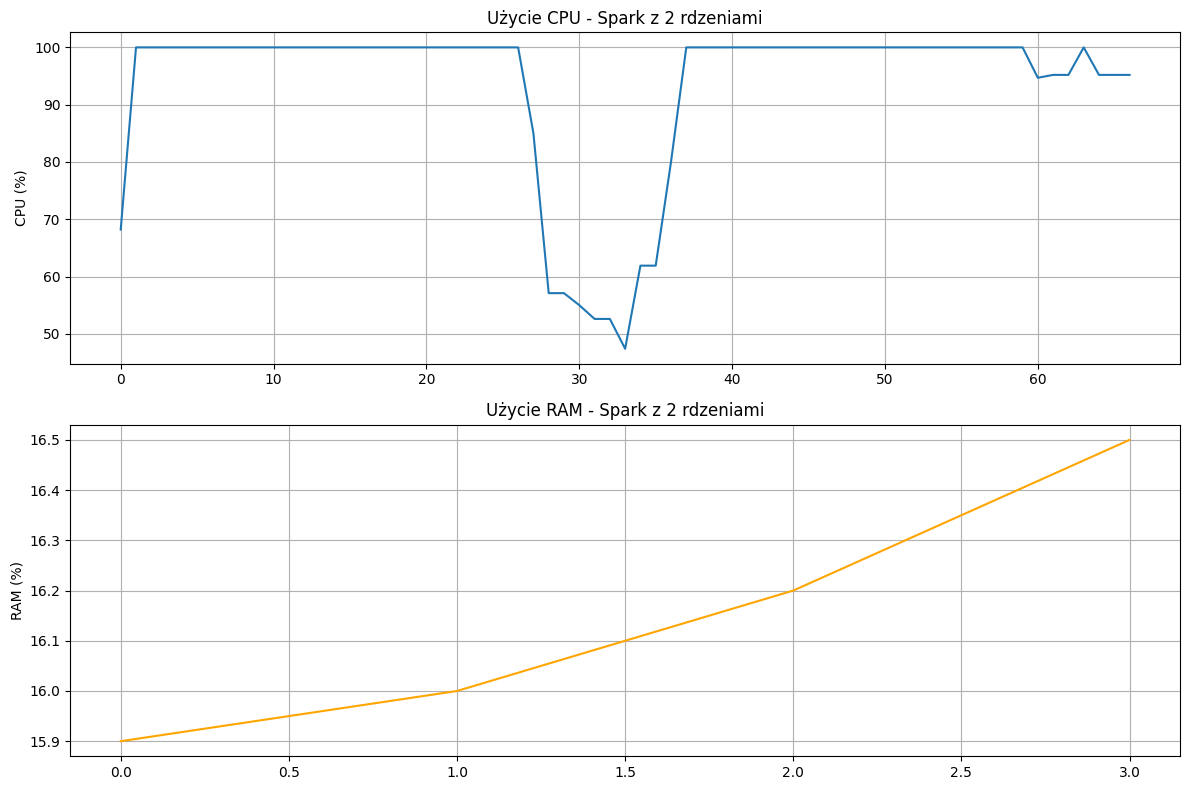


Test Spark z 4 rdzeniami...
Czas wykonania: 2.35 sekund
Średnie użycie CPU: 85.8%
Średnie użycie RAM: 16.4%


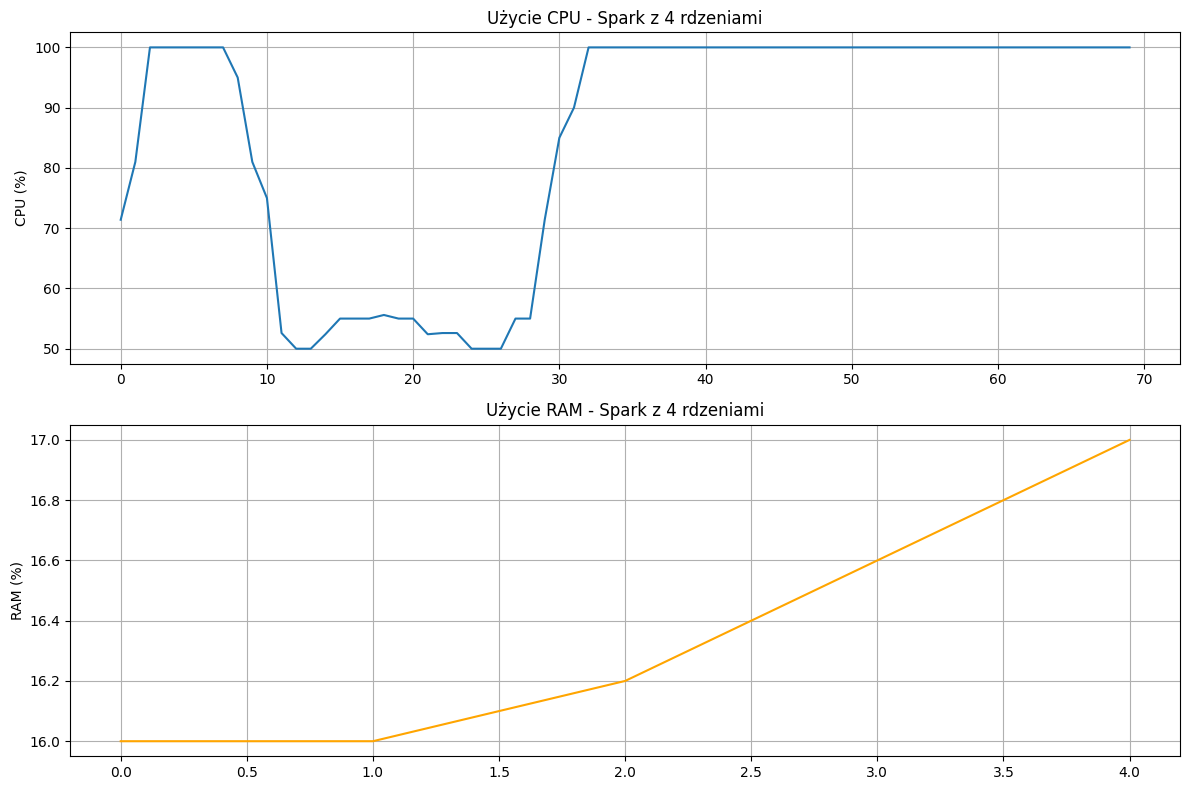


Test Spark z * rdzeniami...
Czas wykonania: 2.26 sekund
Średnie użycie CPU: 85.0%
Średnie użycie RAM: 16.2%


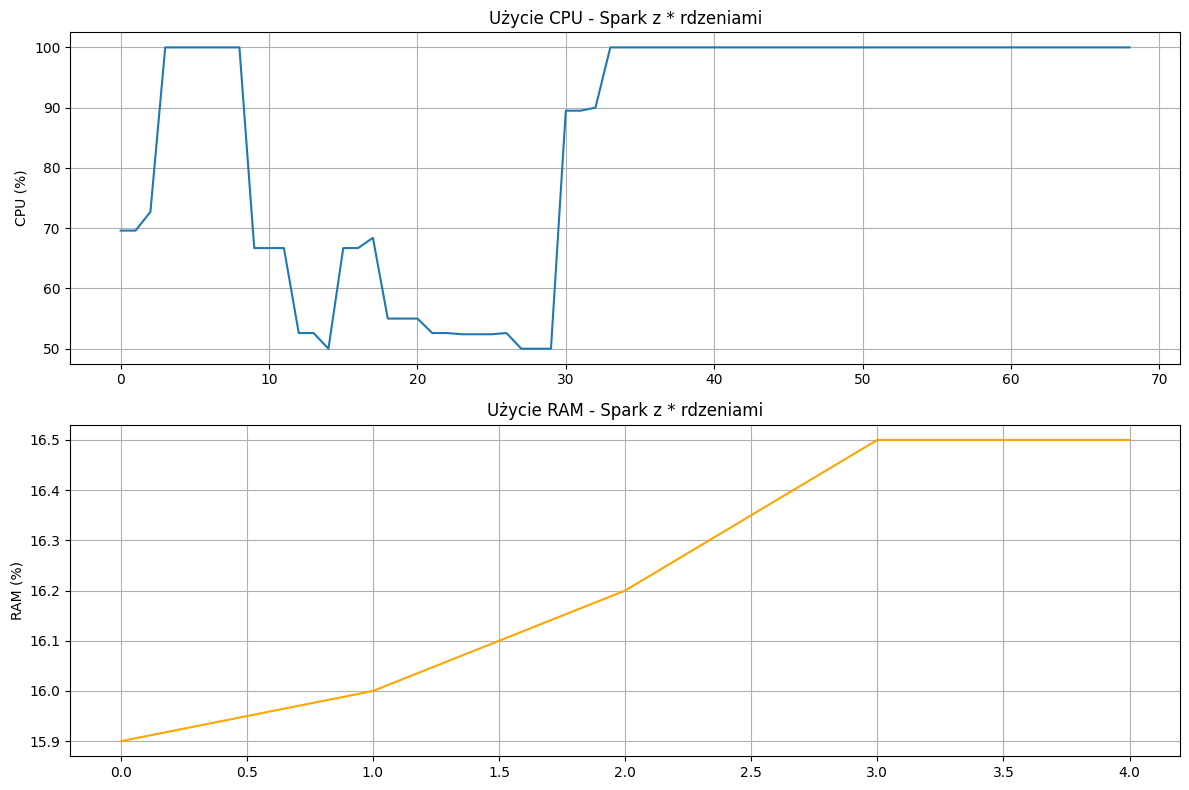

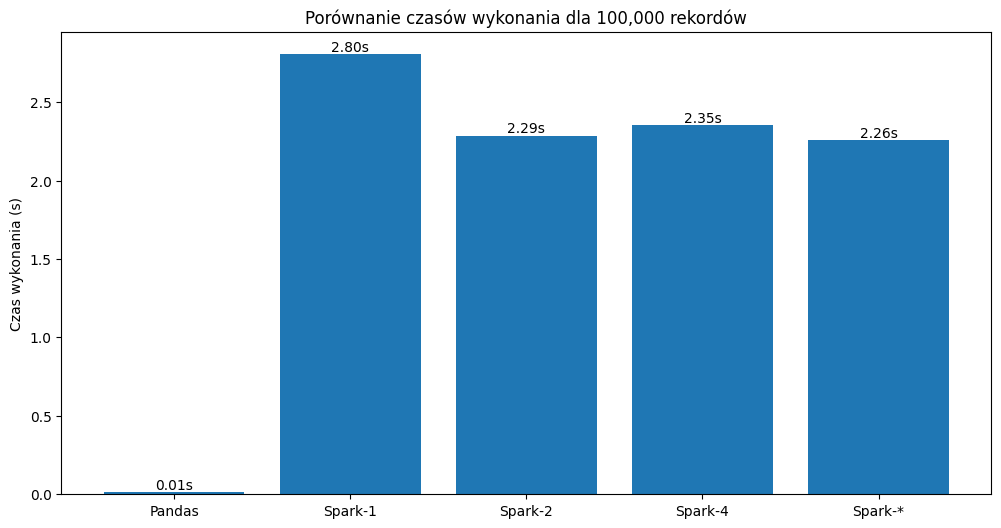


Test dla 1,000,000 rekordów
--------------------------------------------------
Uruchamiam test Pandas...
Czas Pandas: 0.03 sekund

Test Spark z 1 rdzeniami...
Czas wykonania: 3.71 sekund
Średnie użycie CPU: 89.7%
Średnie użycie RAM: 17.8%


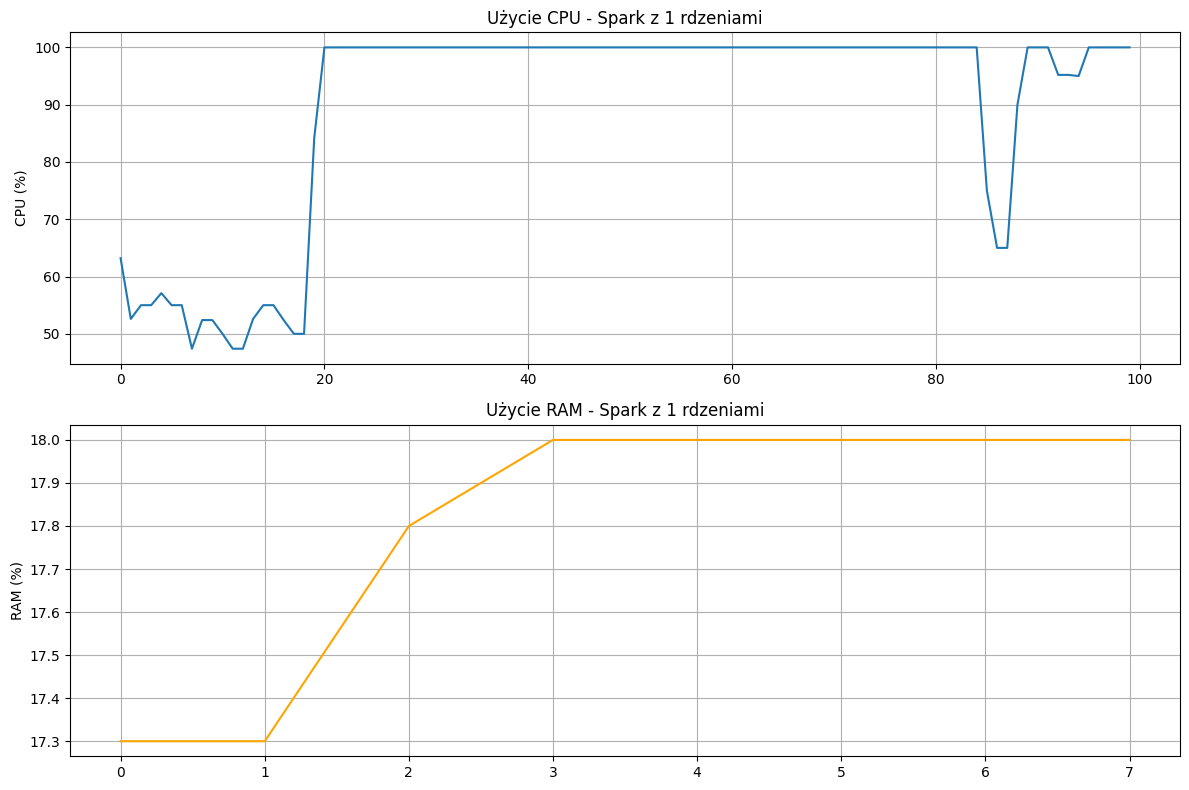


Test Spark z 2 rdzeniami...
Czas wykonania: 3.12 sekund
Średnie użycie CPU: 88.5%
Średnie użycie RAM: 18.2%


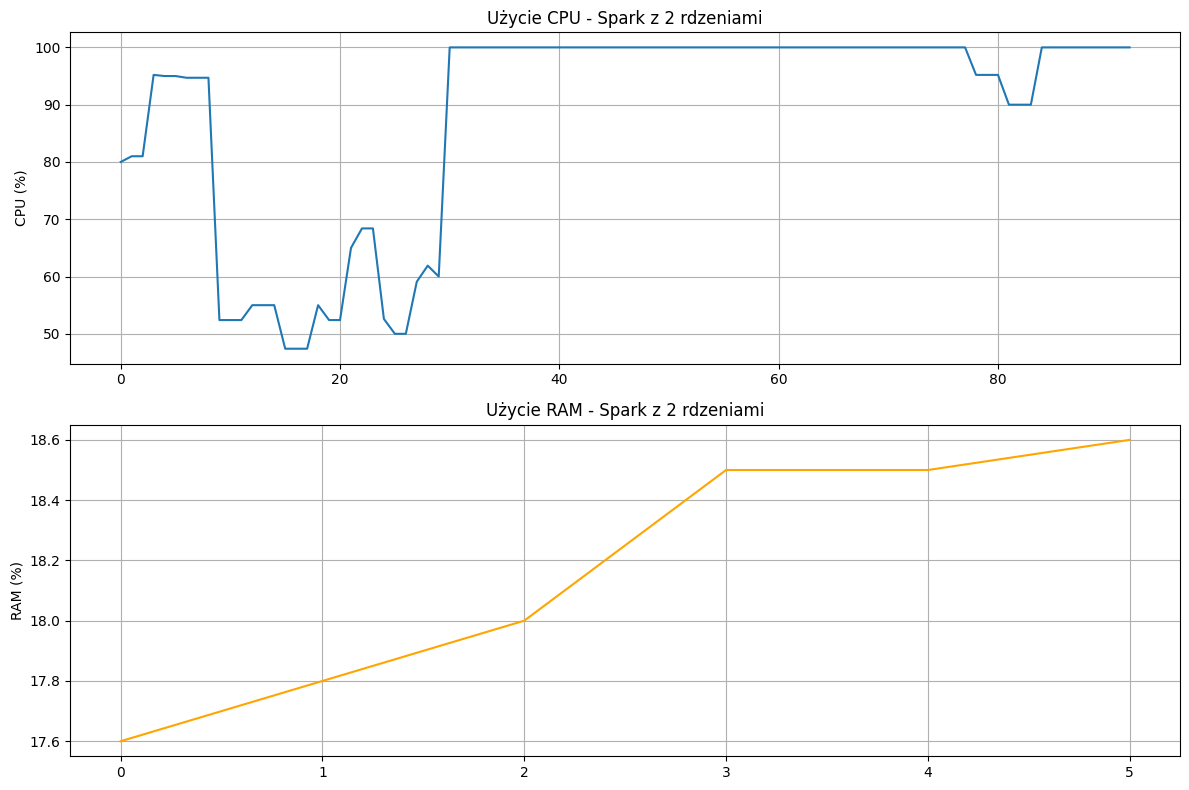


Test Spark z 4 rdzeniami...
Czas wykonania: 3.82 sekund
Średnie użycie CPU: 98.3%
Średnie użycie RAM: 18.8%


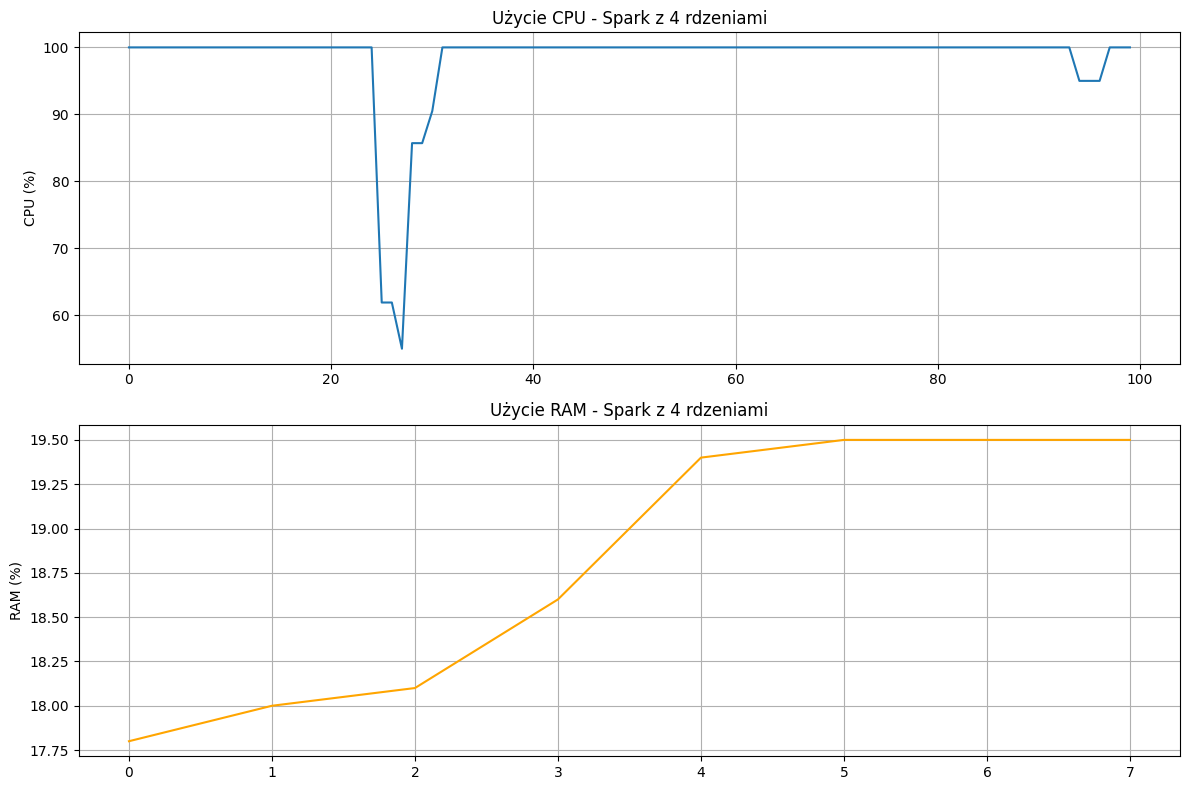


Test Spark z * rdzeniami...
Czas wykonania: 3.26 sekund
Średnie użycie CPU: 89.5%
Średnie użycie RAM: 19.2%


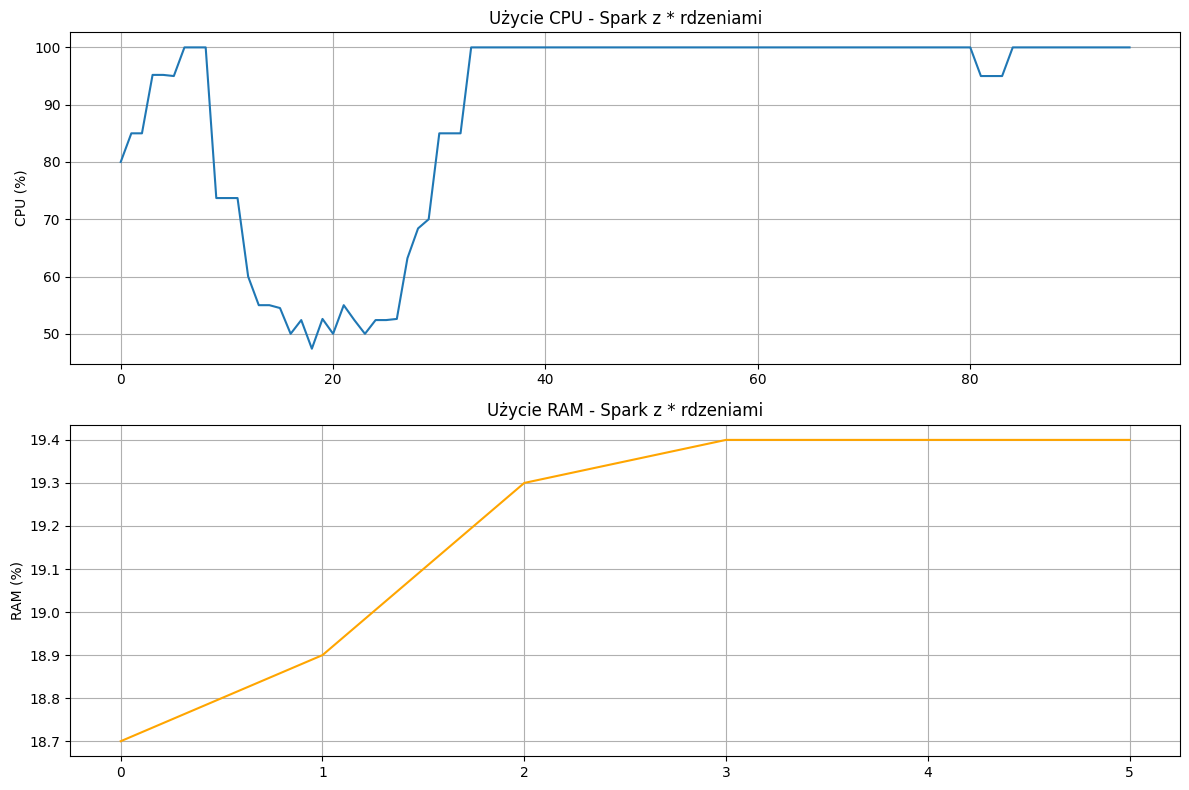

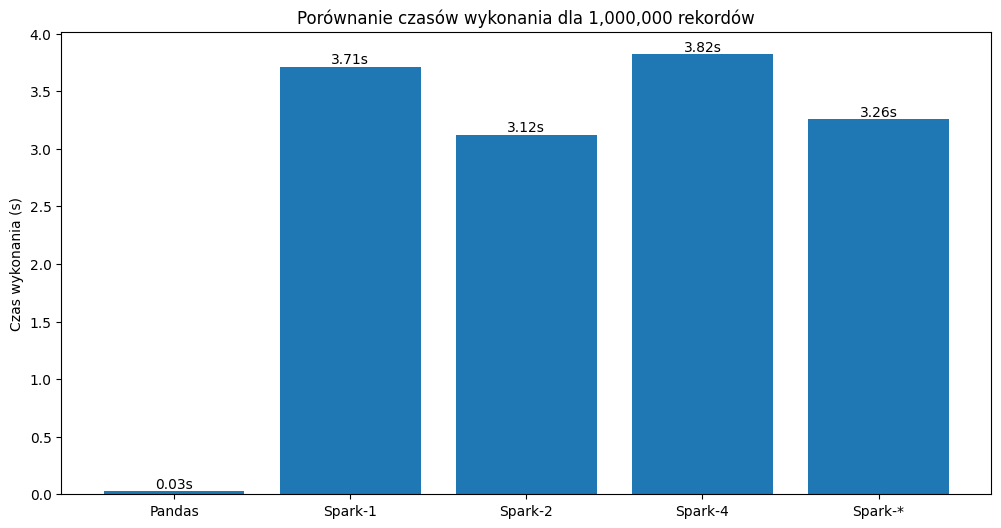


Test dla 5,000,000 rekordów
--------------------------------------------------
Uruchamiam test Pandas...
Czas Pandas: 0.07 sekund

Test Spark z 1 rdzeniami...
Czas wykonania: 9.19 sekund
Średnie użycie CPU: 95.9%
Średnie użycie RAM: 26.6%


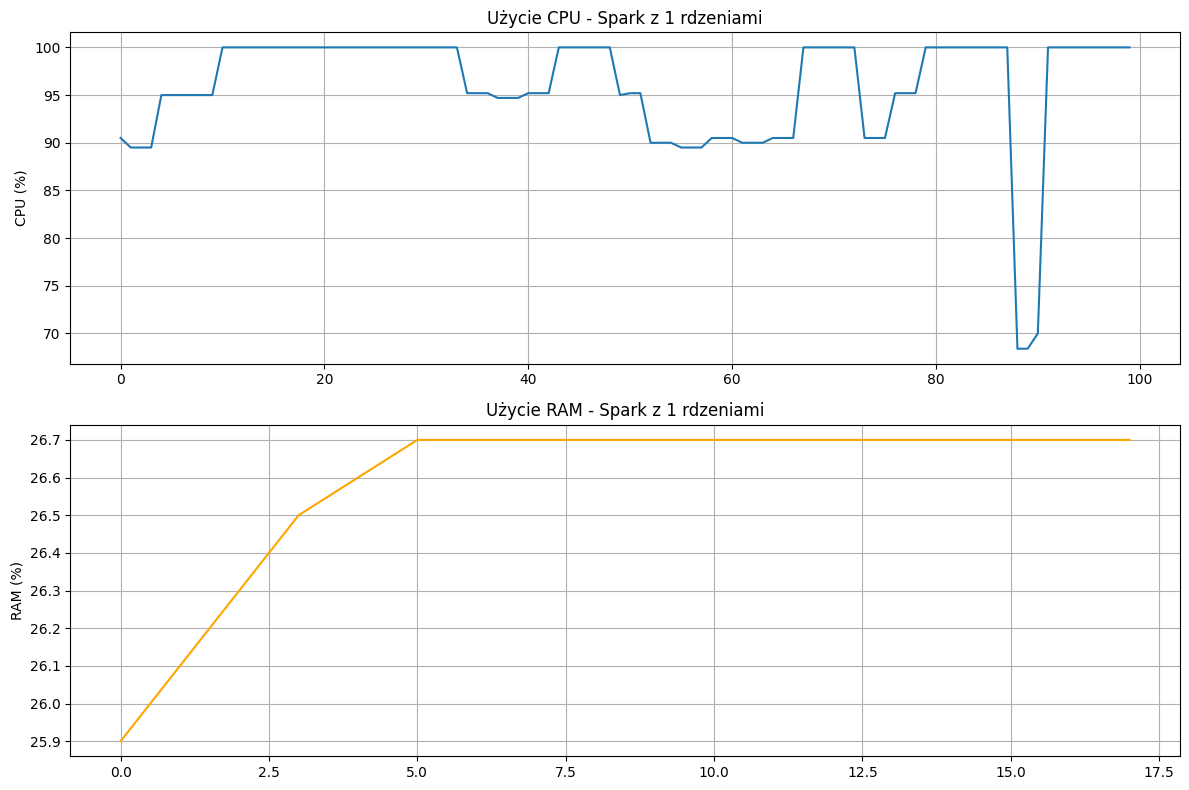


Test Spark z 2 rdzeniami...
Czas wykonania: 7.95 sekund
Średnie użycie CPU: 99.0%
Średnie użycie RAM: 27.5%


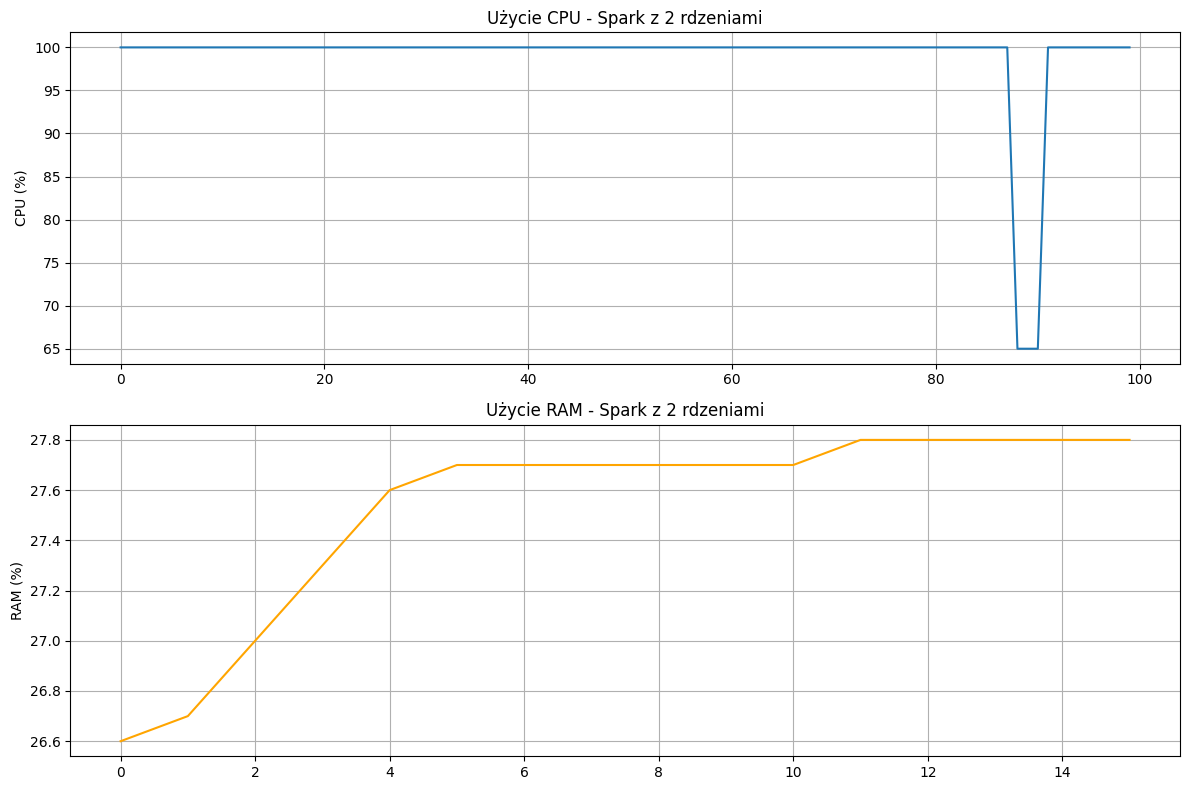


Test Spark z 4 rdzeniami...
Czas wykonania: 9.72 sekund
Średnie użycie CPU: 100.0%
Średnie użycie RAM: 29.2%


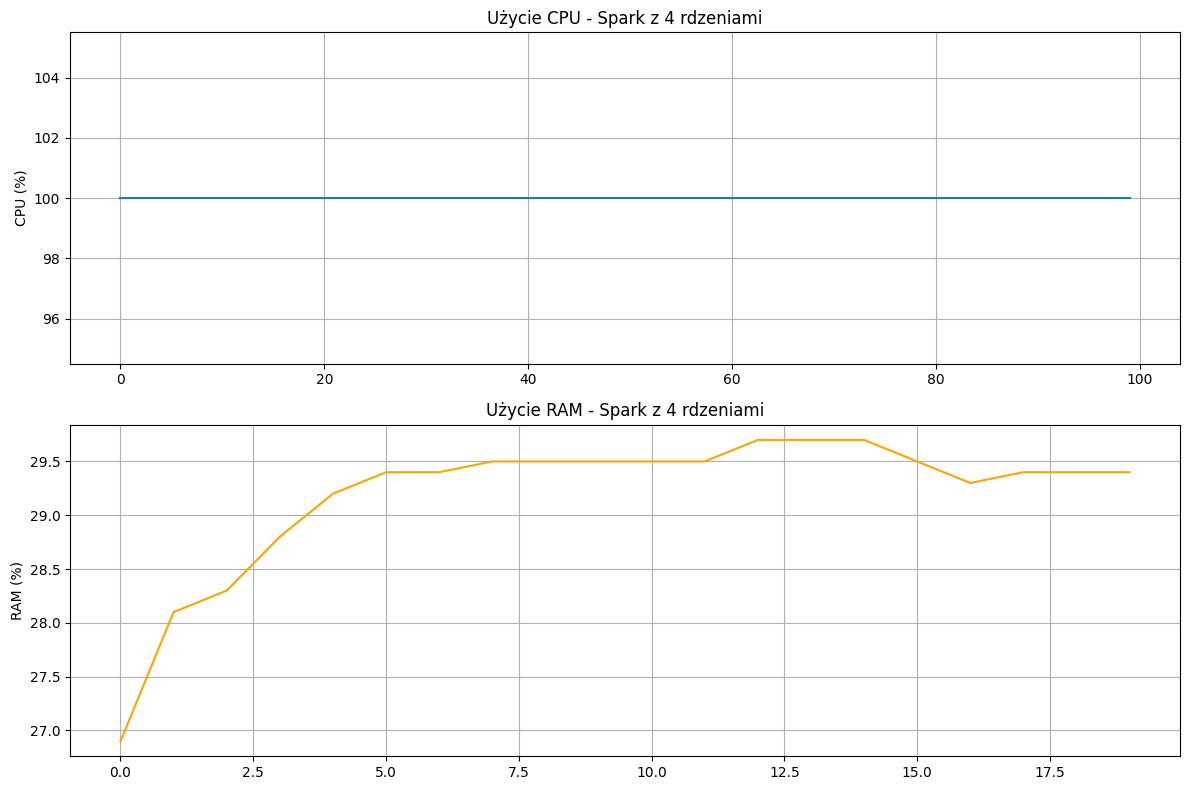


Test Spark z * rdzeniami...
Czas wykonania: 9.28 sekund
Średnie użycie CPU: 99.7%
Średnie użycie RAM: 29.0%


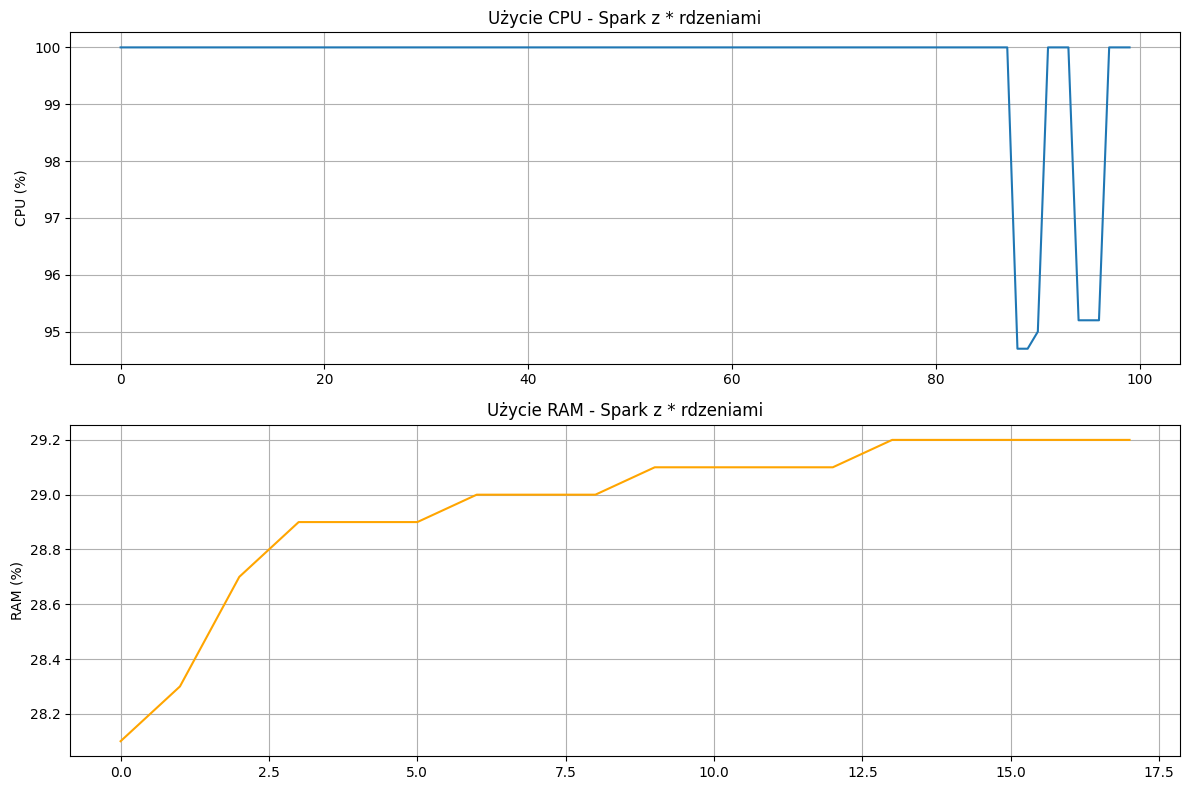

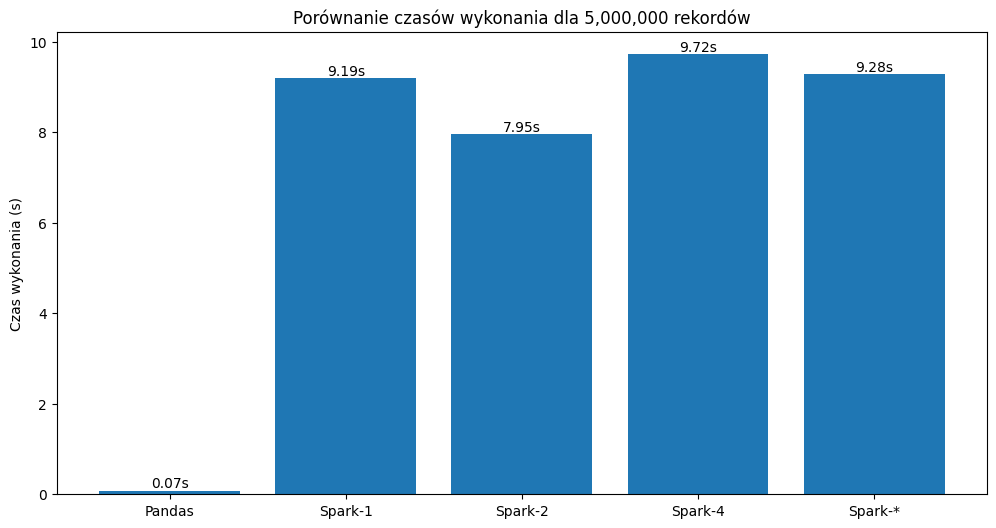

In [9]:
# Import niezbędnych bibliotek
import time
from pyspark.sql import SparkSession
import numpy as np
import pandas as pd
import psutil
import matplotlib.pyplot as plt
from threading import Thread
import queue

# Konfiguracja parametrów testu
DATA_SIZES = [100000, 1000000, 5000000]  # Różne rozmiary danych do testów
CPU_SAMPLE_INTERVAL = 0.1  # Interwał próbkowania CPU w sekundach
MEMORY_SAMPLE_INTERVAL = 0.5  # Interwał próbkowania RAM w sekundach

# Kolejki do monitorowania zasobów
cpu_usage_queue = queue.Queue()
memory_usage_queue = queue.Queue()

# Funkcja monitorująca CPU
def monitor_cpu():
   while True:
       # Pobierz procent wykorzystania CPU
       cpu_percent = psutil.cpu_percent(interval=CPU_SAMPLE_INTERVAL)
       cpu_usage_queue.put(cpu_percent)
       if cpu_usage_queue.qsize() > 100:  # Ogranicz historię pomiarów
           cpu_usage_queue.get()

# Funkcja monitorująca pamięć RAM
def monitor_memory():
   while True:
       # Pobierz informacje o wykorzystaniu pamięci
       memory = psutil.virtual_memory()
       memory_usage_queue.put(memory.percent)
       if memory_usage_queue.qsize() > 100:  # Ogranicz historię pomiarów
           memory_usage_queue.get()
       time.sleep(MEMORY_SAMPLE_INTERVAL)

# Funkcja wykonująca złożone operacje na danych
def complex_operations(df):
   """Wykonuje serię złożonych operacji na DataFrame"""
   return (df
           .groupBy("value")  # Grupowanie po wartości
           .agg({"id": "count"})  # Liczenie wystąpień
           .withColumn("square", df.value * df.value)  # Dodanie kolumny z kwadratem
           .filter(df.value > 5)  # Filtrowanie
           .orderBy("value", ascending=False)  # Sortowanie
           .collect())  # Zebranie wyników

def run_performance_test(data_size):
   # Przygotowanie danych testowych
   print(f"\nTest dla {data_size:,} rekordów")
   print("-" * 50)
   data = [(i, i % 10, float(i)/data_size) for i in range(data_size)]  # Dodano kolumnę z wartościami zmiennoprzecinkowymi

   # Test Pandas
   print("Uruchamiam test Pandas...")
   df_pandas = pd.DataFrame(data, columns=["id", "value", "float_val"])
   start_time = time.time()
   # Złożone operacje w Pandas
   result_pandas = (df_pandas
                   .groupby("value")
                   .agg({"id": "count"})
                   .assign(square=lambda x: x.index * x.index)
                   .query("value > 5")
                   .sort_values("value", ascending=False))
   pandas_time = time.time() - start_time
   print(f"Czas Pandas: {pandas_time:.2f} sekund")

   # Testy Spark dla różnych konfiguracji rdzeni
   spark_times = []
   cores_list = [1, 2, 4, '*']
   memory_usage = []

   for cores in cores_list:
       print(f"\nTest Spark z {cores} rdzeniami...")
       # Restart sesji Spark
       SparkSession.builder.getOrCreate().stop()

       # Konfiguracja nowej sesji Spark z określoną liczbą rdzeni
       spark = (SparkSession.builder
               .appName(f"SparkCores_{cores}")
               .master(f"local[{cores}]")
               .config("spark.memory.fraction", 0.8)  # Konfiguracja pamięci
               .config("spark.executor.memory", "2g")
               .getOrCreate())

       # Utworzenie DataFrame Spark
       df_spark = spark.createDataFrame(data, ["id", "value", "float_val"])

       # Czyszczenie kolejek monitorowania
       while not cpu_usage_queue.empty(): cpu_usage_queue.get()
       while not memory_usage_queue.empty(): memory_usage_queue.get()

       # Wykonanie testu
       start_time = time.time()
       result_spark = complex_operations(df_spark)
       spark_time = time.time() - start_time

       # Zebranie statystyk CPU i RAM
       cpu_usage = []
       while not cpu_usage_queue.empty():
           cpu_usage.append(cpu_usage_queue.get())

       mem_usage = []
       while not memory_usage_queue.empty():
           mem_usage.append(memory_usage_queue.get())

       # Wyświetlenie wyników
       print(f"Czas wykonania: {spark_time:.2f} sekund")
       print(f"Średnie użycie CPU: {np.mean(cpu_usage):.1f}%")
       print(f"Średnie użycie RAM: {np.mean(mem_usage if mem_usage else [0]):.1f}%")

       spark_times.append(spark_time)
       memory_usage.append(np.mean(mem_usage if mem_usage else [0]))

       # Wykres użycia zasobów
       fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

       # Wykres CPU
       ax1.plot(cpu_usage, label='CPU')
       ax1.set_title(f'Użycie CPU - Spark z {cores} rdzeniami')
       ax1.set_ylabel('CPU (%)')
       ax1.grid(True)

       # Wykres RAM
       ax2.plot(mem_usage, label='RAM', color='orange')
       ax2.set_title(f'Użycie RAM - Spark z {cores} rdzeniami')
       ax2.set_ylabel('RAM (%)')
       ax2.grid(True)

       plt.tight_layout()
       plt.show()

   # Wykres porównawczy wszystkich czasów
   plt.figure(figsize=(12, 6))
   bars = plt.bar(range(len(cores_list) + 1), [pandas_time] + spark_times)
   plt.xticks(range(len(cores_list) + 1), ['Pandas'] + [f'Spark-{c}' for c in cores_list])
   plt.ylabel('Czas wykonania (s)')
   plt.title(f'Porównanie czasów wykonania dla {data_size:,} rekordów')

   # Dodanie etykiet nad słupkami
   for bar in bars:
       height = bar.get_height()
       plt.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.2f}s',
               ha='center', va='bottom')

   plt.show()

# Start wątków monitorujących
monitor_cpu_thread = Thread(target=monitor_cpu, daemon=True)
monitor_memory_thread = Thread(target=monitor_memory, daemon=True)
monitor_cpu_thread.start()
monitor_memory_thread.start()

# Wykonanie testów dla różnych rozmiarów danych
for size in DATA_SIZES:
   run_performance_test(size)